# Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report

import numpy as np
import pandas as pd

import os

rf_distance = RandomForestClassifier(random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
data_path = os.path.join('..', 'data', 'data.csv')
df = pd.read_csv(data_path)






# Definisco le variabili feature
features = ['wind_direction', 'concentration', 'U', 'q']
target = 'distance'
X = df[features]
# Definisco la variabile target
y = df[target]



In [4]:
#Stampo la distribuzione delle classsi
print(y.value_counts())

distance
50     1081
100     963
200     792
Name: count, dtype: int64


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Faccio la cross-validation del modello
cv_scores = cross_val_score(rf_distance, X_train, y_train, cv=kf, scoring='accuracy')
print("Cross-validation scores:", cv_scores)


trained_model = rf_distance.fit(X_train, y_train)
# Predizioni sul test set
y_test_pred = trained_model.predict(X_test)
# Valuto le prestazioni del modello
accuracy = accuracy_score(y_test, y_test_pred)
print("Test set accuracy:", accuracy)
print("Classification report:\n", classification_report(y_test, y_test_pred))

Cross-validation scores: [0.75110132 0.74449339 0.74669604 0.7196468  0.75055188]
Test set accuracy: 0.7623239436619719
Classification report:
               precision    recall  f1-score   support

          50       0.82      0.82      0.82       234
         100       0.66      0.68      0.67       182
         200       0.80      0.78      0.79       152

    accuracy                           0.76       568
   macro avg       0.76      0.76      0.76       568
weighted avg       0.76      0.76      0.76       568



### Matrice di confusione

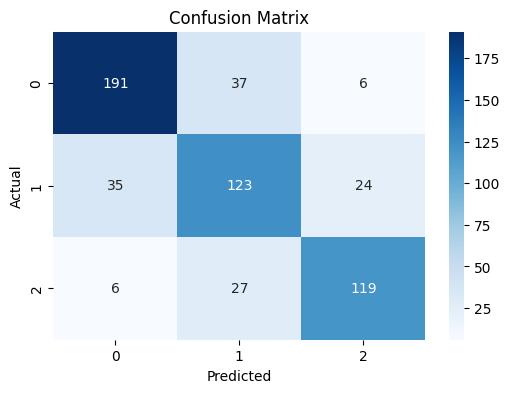

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Curva ROC e AUC

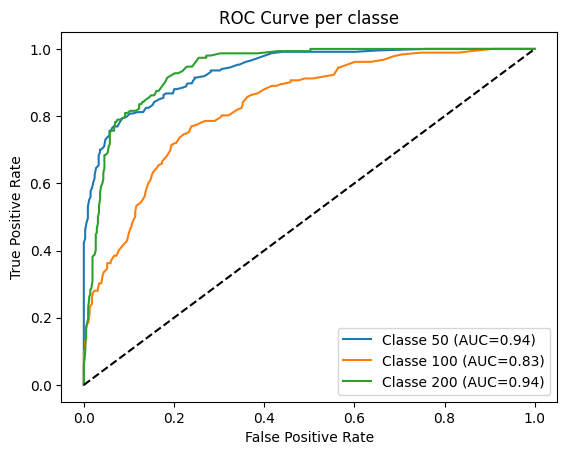

In [7]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_test_bin = label_binarize(y_test, classes=np.unique(y))
y_score = trained_model.predict_proba(X_test)
for i, class_label in enumerate(np.unique(y)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    plt.plot(fpr, tpr, label=f'Classe {class_label} (AUC={auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per classe')
plt.legend()
plt.show()

### Precision-Recall Curve

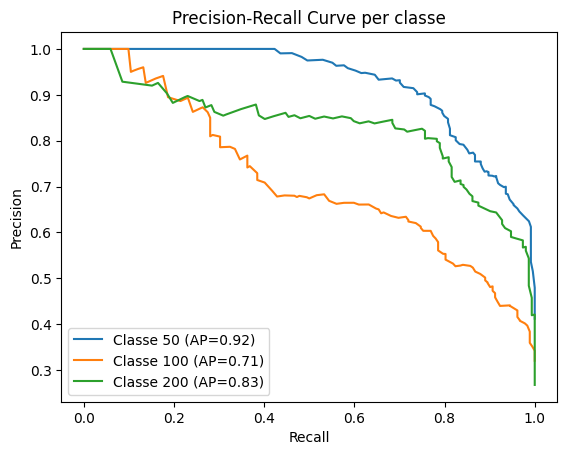

In [8]:
from sklearn.metrics import precision_recall_curve, average_precision_score

for i, class_label in enumerate(np.unique(y)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, label=f'Classe {class_label} (AP={average_precision_score(y_test_bin[:, i], y_score[:, i]):.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve per classe')
plt.legend()
plt.show()

### Learning curve

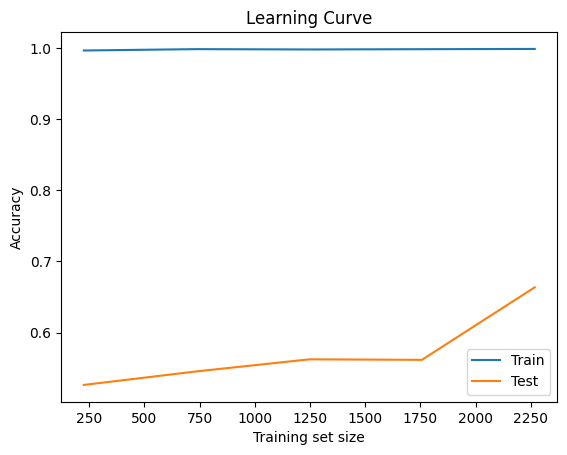

In [9]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(trained_model, X, y, cv=5)
plt.plot(train_sizes, train_scores.mean(axis=1), label='Train')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Test')
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

### Feature importance

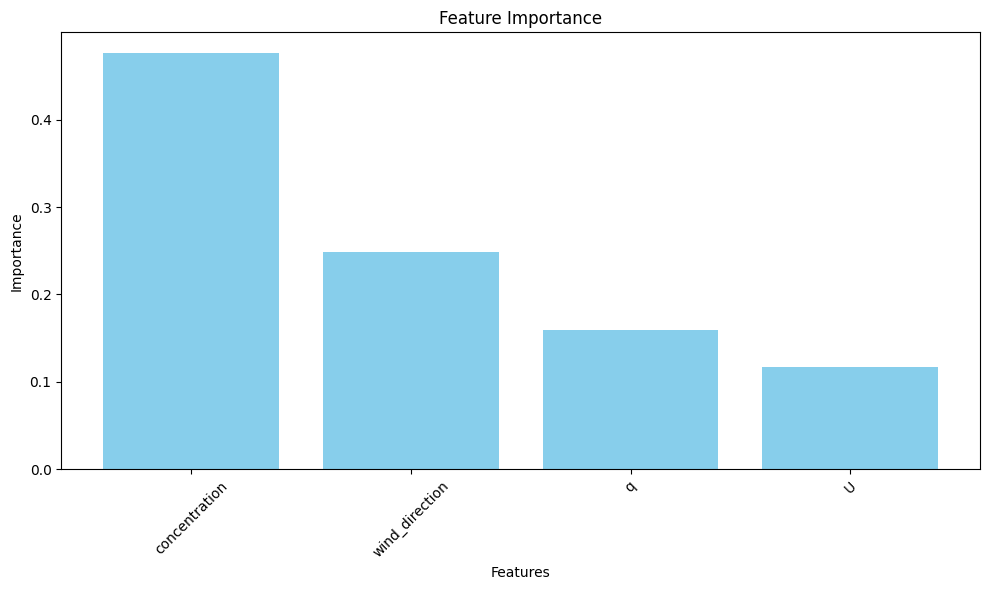

In [10]:


# Feature importance
importances = pd.DataFrame({
    'Feature': features,
    'Importance': trained_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
# Plotto le feature importance
plt.figure(figsize=(10, 6))
plt.bar(importances['Feature'], importances['Importance'], color='skyblue')
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
# Metriche di valutazione
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

print("Classification Report:")
print("Accuracy: ", accuracy_score(y_test, y_test_pred))


Classification Report:
Accuracy:  0.7623239436619719


In [12]:
# Predizione su nuovi dati
def predict_distance( wind_direction, concentration, Wind_Speed, Source_strength):
    new_sample = pd.DataFrame([[ wind_direction, concentration, Wind_Speed, Source_strength]], columns=features)
    prediction = trained_model.predict(new_sample)[0]
    probabilities = trained_model.predict_proba(new_sample)[0]
    print(f"Predicted distance: {prediction} metri")
    print(f"Probabilities per classe:")
    for i, prob in enumerate(probabilities):
        print(f"Classe {i} m: {prob:.2f}")
    return prediction

In [13]:
# Esempio di predizione
predict_distance( wind_direction=45, concentration=5, Wind_Speed=10, Source_strength=3)


Predicted distance: 100 metri
Probabilities per classe:
Classe 0 m: 0.27
Classe 1 m: 0.62
Classe 2 m: 0.11


np.int64(100)

In [14]:
# Ottimizzazione del modello
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],         # Numero di alberi nella foresta
    'max_depth': [None, 10, 20],            # Profondità massima degli alberi
    'min_samples_split': [2, 5, 10],        # Minimo numero di campioni per dividere un nodo
    'min_samples_leaf': [1, 2, 4],          # Minimo numero di campioni in una foglia
    'max_features': ['auto', 'sqrt', 'log2'], # Numero di feature da considerare a ogni split
    'bootstrap': [True, False],             # bootstrap per campionamento
    'class_weight': ['balanced', None] 
}

grid_search = GridSearchCV(estimator=trained_model, param_grid=param_grid, cv=kf, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

Best parameters found:  {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score:  0.7544038276395251


c:\Users\abbon\miniconda3\envs\DA\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
1620 fits failed out of a total of 4860.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1012 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\abbon\miniconda3\envs\DA\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\abbon\miniconda3\envs\DA\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "c:\Users\abbon\miniconda3\envs\DA\Lib\site-packages\sklearn\ba

In [15]:
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)
y_test_pred = best_rf.predict(X_test)
print("Classification report for best model:\n", classification_report(y_test, y_test_pred))

Classification report for best model:
               precision    recall  f1-score   support

          50       0.83      0.82      0.82       234
         100       0.63      0.66      0.65       182
         200       0.81      0.78      0.79       152

    accuracy                           0.76       568
   macro avg       0.76      0.75      0.75       568
weighted avg       0.76      0.76      0.76       568



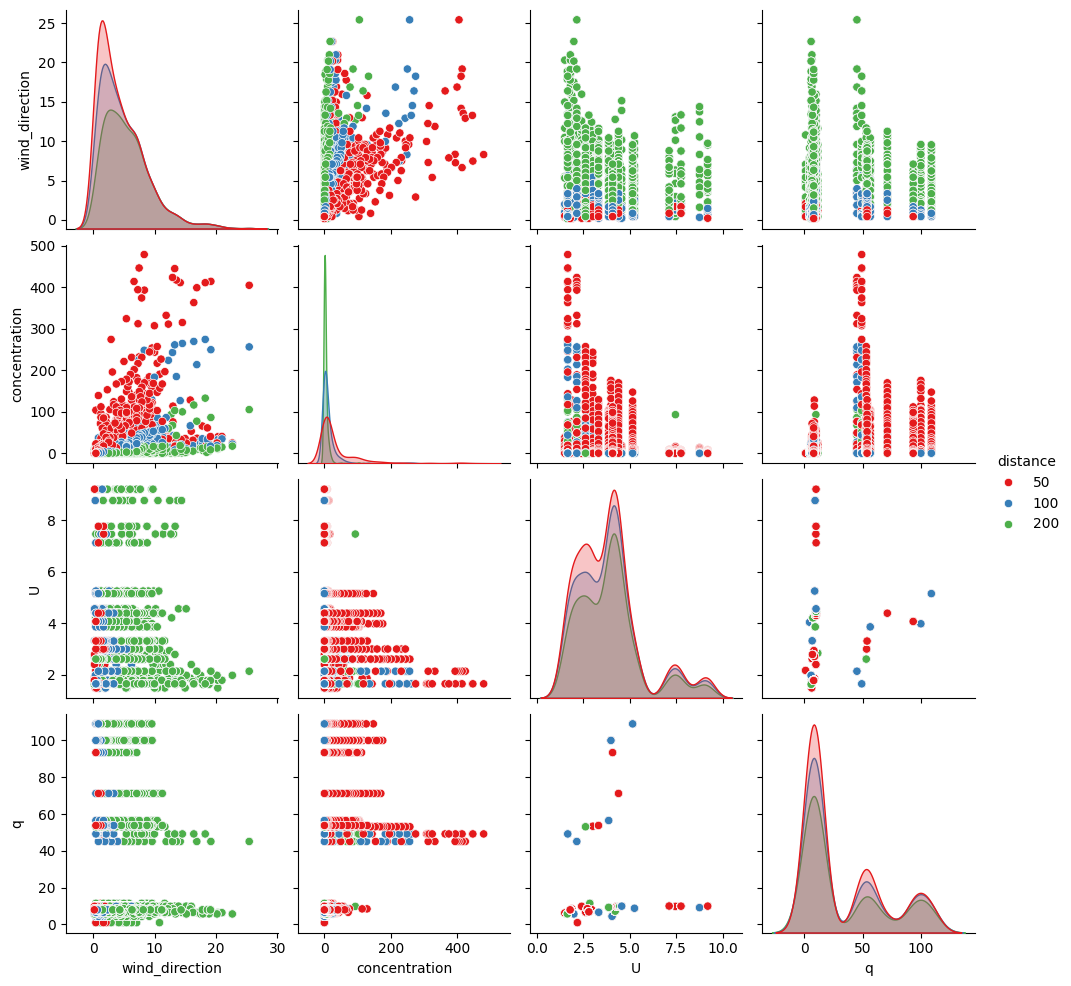

In [16]:
sns.pairplot(df, vars=features, hue='distance', palette='Set1')
plt.show()

Dal pair plot si evince un problema di sovrapposizione di punti associati a classi diverse: nello specifico la classe 100 è quella più propensa ad un'errata predizione, perchè è una classe intermedia che si sovrappone con le altre. I grafici concentration-wind_direction e viceversa mostrano perfettamente questo fenomeno. Si registra pertanto un problema intrinseco al dataset. 

### Cambio train/test e validation

In [ ]:
#Cambio train e test set

data_path_train_test = os.path.join('..', 'data', 'data2_model_before_parsing.csv')
data_path_val = os.path.join('..', 'data', 'data1_model_before_parsing.csv')
df_train_test = pd.read_csv(data_path_train_test)
df_val = pd.read_csv(data_path_val)


In [18]:

df_train_test.count()

post              1073
azimuth           1073
wind_direction    1073
concentration     1073
distance          1073
U                 1073
q                 1073
dtype: int64

In [19]:
df_val.count()

post              1763
azimuth           1763
wind_direction    1763
concentration     1763
distance          1763
U                 1763
q                 1763
dtype: int64

In [20]:
#Splitto il df_train_test
train_df, test_df = train_test_split(df_train_test, test_size=0.2, random_state=42)

#Cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_distance, train_df[features], train_df[target], cv=kf, scoring='accuracy')
print("Cross-validation scores for best model:", cv_scores)
print("Mean cross-validation score for best model:", cv_scores.mean())

#Fitto il modello
rf_distance.fit(train_df[features], train_df[target])
# Predizioni sul test set
predictions = rf_distance.predict(test_df[features])
# Determino la predizione sul validation set
val_predictions = rf_distance.predict(df_val[features])
# Valuto le prestazioni del modello sul test set
y_val = df_val[target]


Cross-validation scores for best model: [0.80232558 0.8255814  0.80813953 0.78362573 0.77777778]
Mean cross-validation score for best model: 0.7994900040799673


In [21]:
#Accuracy sul test set
test_accuracy = accuracy_score(test_df[target], predictions)
print("Test set accuracy for best model:", test_accuracy)

Test set accuracy for best model: 0.7302325581395349


In [22]:
#Classification report sul test set
print("Classification report for test set:\n", classification_report(test_df[target], predictions))

Classification report for test set:
               precision    recall  f1-score   support

          50       0.86      0.74      0.79        80
         100       0.61      0.71      0.65        75
         200       0.76      0.75      0.76        60

    accuracy                           0.73       215
   macro avg       0.74      0.73      0.73       215
weighted avg       0.74      0.73      0.73       215



In [23]:

#1. Accuracy
accuracy_val = accuracy_score(val_predictions, y_val)
print("Validation set accuracy:", accuracy_val)


Validation set accuracy: 0.39931934203062963


In [24]:

#2. Classification report
print("Classification report for validation set:\n", classification_report(y_val, val_predictions))


Classification report for validation set:
               precision    recall  f1-score   support

          50       0.70      0.24      0.35       675
         100       0.32      0.38      0.35       594
         200       0.38      0.65      0.48       494

    accuracy                           0.40      1763
   macro avg       0.47      0.42      0.39      1763
weighted avg       0.48      0.40      0.39      1763



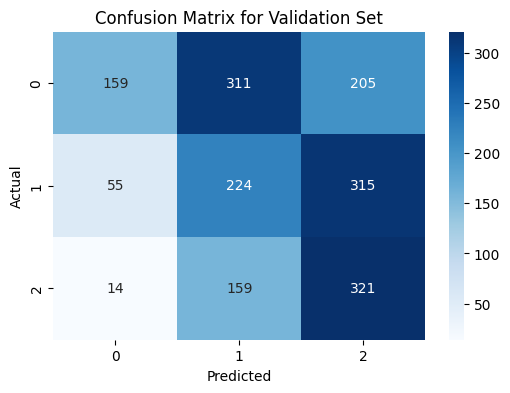

In [25]:

#3. Confusion matrix
cm_val = confusion_matrix(y_val, val_predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Validation Set')
plt.show()



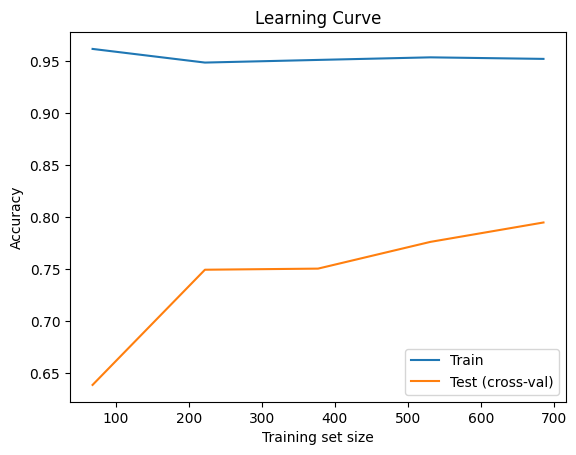

In [26]:
# Learning curve

train_sizes, train_scores, test_scores = learning_curve(
    best_rf, 
    train_df[features], 
    train_df[target], 
    cv=5, 
    scoring='accuracy'
)

plt.plot(train_sizes, train_scores.mean(axis=1), label='Train')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Test (cross-val)')
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

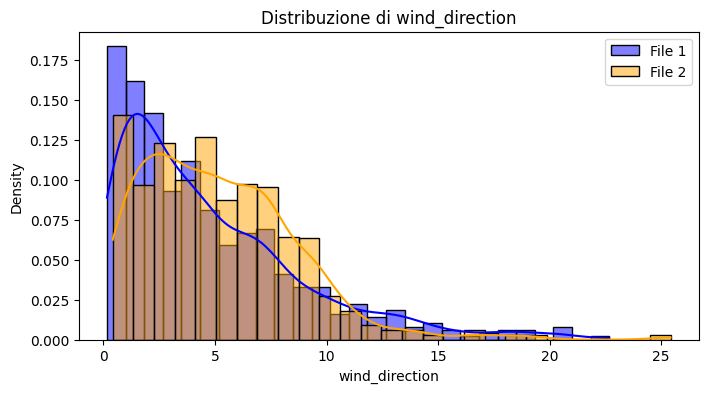

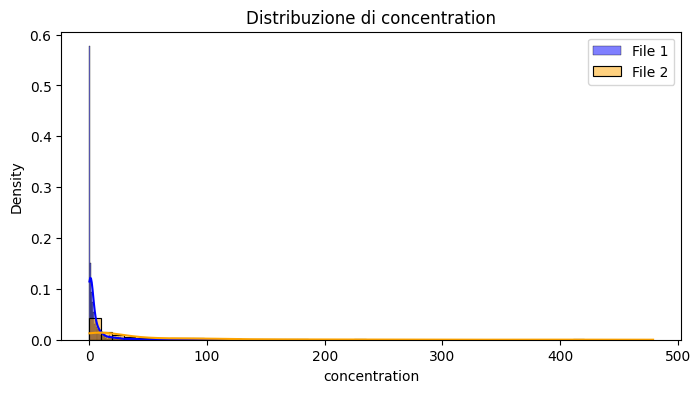

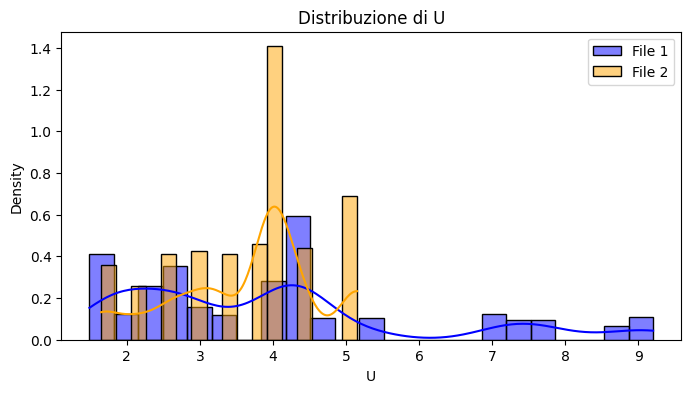

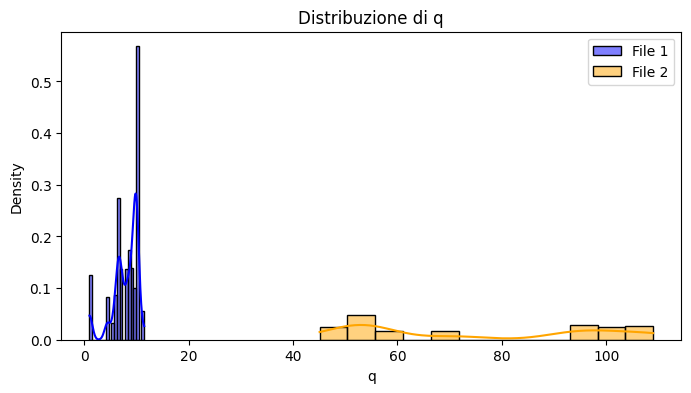

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carica i due file
df1 = pd.read_csv('..\\data\\data1_model_before_parsing.csv')
df2 = pd.read_csv('..\\data\\data2_model_before_parsing.csv')

features = ['wind_direction', 'concentration', 'U', 'q']

# Istogrammi affiancati per ogni feature
for feature in features:
    plt.figure(figsize=(8, 4))
    sns.histplot(df1[feature], color='blue', label='File 1', kde=True, stat='density', alpha=0.5)
    sns.histplot(df2[feature], color='orange', label='File 2', kde=True, stat='density', alpha=0.5)
    plt.title(f'Distribuzione di {feature}')
    plt.legend()
    plt.show()


## Random Forest for Azimuth prediction

In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, explained_variance_score, root_mean_squared_error, mean_absolute_error

target_azimuth = 'azimuth'
X = df[features]
y_azimuth = df[target_azimuth]

X_train_azimuth, X_test_azimuth, y_train_azimuth, y_test_azimuth = train_test_split(X, y_azimuth, test_size=0.2, random_state=42)

rf_azimuth = RandomForestRegressor(random_state=42)
rf_azimuth.fit(X_train_azimuth, y_train_azimuth)

# Predizioni sul test set per l'azimuth
y_test_pred_azimuth = rf_azimuth.predict(X_test_azimuth)


In [39]:

# Valuto le prestazioni del modello per l'azimuth
mse = mean_squared_error(y_test_azimuth, y_test_pred_azimuth)
rmse = root_mean_squared_error(y_test_azimuth, y_test_pred_azimuth)
mae = mean_absolute_error(y_test_azimuth, y_test_pred_azimuth)
r2 = rf_azimuth.score(X_test_azimuth, y_test_azimuth)
evs = explained_variance_score(y_test_azimuth, y_test_pred_azimuth)
print("Test set MSE for azimuth:", mse)
print("Root Mean Squared Error for azimuth:", rmse)
print("Mean Absolute Error for azimuth:", mae)
print("Explained Variance Score for azimuth:", evs)
print("R^2 score for azimuth:", rf_azimuth.score(X_test_azimuth, y_test_azimuth))


Test set MSE for azimuth: 370.15923171919013
Root Mean Squared Error for azimuth: 19.23952264790346
Mean Absolute Error for azimuth: 13.18018787726358
Explained Variance Score for azimuth: 0.6598456029736783
R^2 score for azimuth: 0.6590536396717384


In [40]:
train_pred = rf_azimuth.predict(X_train_azimuth)
test_pred = rf_azimuth.predict(X_test_azimuth)
mse_train = mean_squared_error(y_train_azimuth, train_pred)
mse_test = mean_squared_error(y_test_azimuth, test_pred)
print("Train MSE:", mse_train)
print("Test MSE:", mse_test)

Train MSE: 62.04209212139532
Test MSE: 370.15923171919013


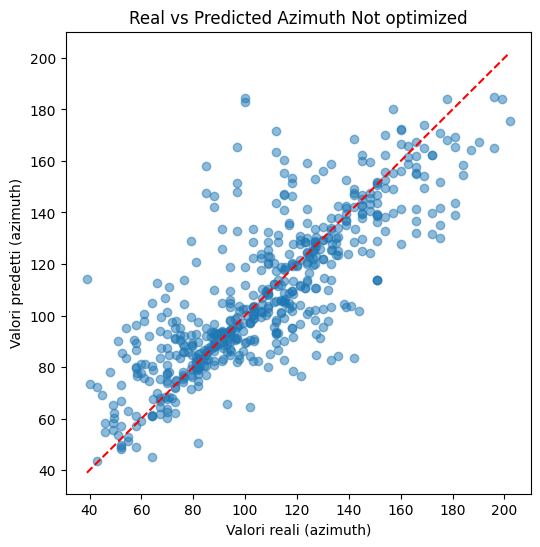

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(y_test_azimuth, y_test_pred_azimuth, alpha=0.5)
plt.plot([y_test_azimuth.min(), y_test_azimuth.max()], [y_test_azimuth.min(), y_test_azimuth.max()], 'r--')
plt.xlabel('Valori reali (azimuth)')
plt.ylabel('Valori predetti (azimuth)')
plt.title('Real vs Predicted Azimuth')
plt.show()

In [31]:
#ottimizzazione del modello per l'azimuth
param_grid_azimuth = {
    'n_estimators': [50, 100, 200], 
    'max_depth': [None, 10, 20],            
    'min_samples_split': [2, 5, 10],        
    'min_samples_leaf': [1, 2, 4],          
    'max_features': ['auto', 'sqrt', 'log2'], 
    'bootstrap': [True, False],             
    
}
grid_search_azimuth = GridSearchCV(estimator=rf_azimuth, param_grid=param_grid_azimuth, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_azimuth.fit(X_train_azimuth, y_train_azimuth)
print("Best parameters for azimuth model found: ", grid_search_azimuth.best_params_)


Best parameters for azimuth model found:  {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


c:\Users\abbon\miniconda3\envs\DA\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
810 fits failed out of a total of 2430.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
560 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\abbon\miniconda3\envs\DA\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\abbon\miniconda3\envs\DA\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "c:\Users\abbon\miniconda3\envs\DA\Lib\site-packages\sklearn\base

In [32]:
# Predizione con il modello ottimizzato
best_rf_azimuth = grid_search_azimuth.best_estimator_
best_rf_azimuth.fit(X_train_azimuth, y_train_azimuth)
y_test_pred_azimuth = best_rf_azimuth.predict(X_test_azimuth)

In [33]:
#Valuto le prestazioni del modello ottimizzato per l'azimuth
mse_optimized = mean_squared_error(y_test_azimuth, y_test_pred_azimuth)
print("Test set MSE for optimized azimuth model:", mse_optimized)
print("R^2 score for optimized azimuth model:", best_rf_azimuth.score(X_test_azimuth, y_test_azimuth))

Test set MSE for optimized azimuth model: 352.0758288990478
R^2 score for optimized azimuth model: 0.675709904990969


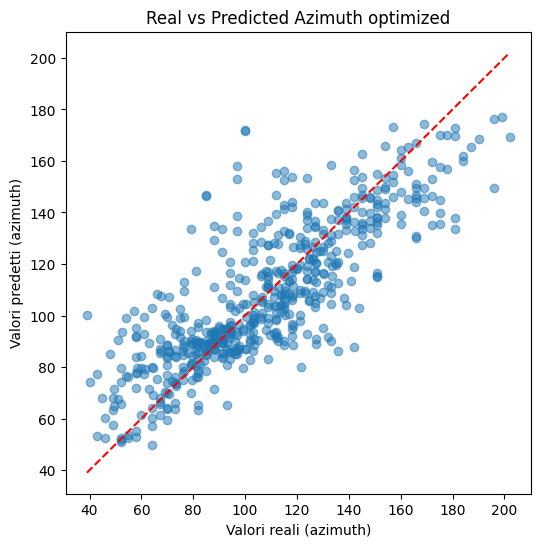

In [34]:

plt.figure(figsize=(6,6))
plt.scatter(y_test_azimuth, y_test_pred_azimuth, alpha=0.5)
plt.plot([y_test_azimuth.min(), y_test_azimuth.max()], [y_test_azimuth.min(), y_test_azimuth.max()], 'r--')
plt.xlabel('Valori reali (azimuth)')
plt.ylabel('Valori predetti (azimuth)')
plt.title('Real vs Predicted Azimuth optimized')
plt.show()

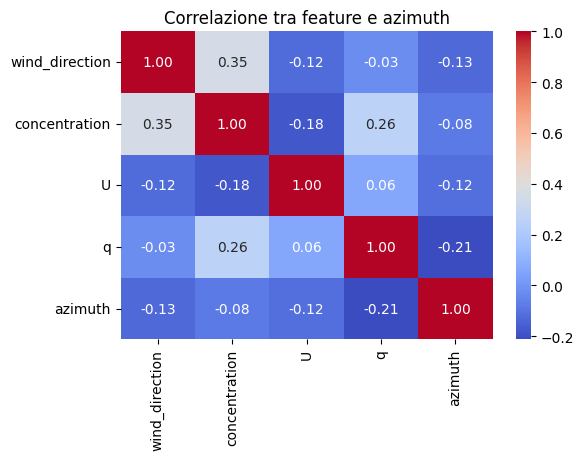

In [35]:

# Unisci le feature e l'azimuth in un unico DataFrame
df_corr = df[features + ['azimuth']]

# Calcola la matrice di correlazione
corr_matrix = df_corr.corr()

# Plotta la heatmap delle correlazioni
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlazione tra feature e azimuth')
plt.show()

### Salvo i modelli

In [36]:
import joblib
# salvo rf_distance
joblib.dump(rf_distance, 'rf_distance_model.pkl')
# salvo rf_azimuth
joblib.dump(best_rf_azimuth, 'rf_azimuth_model.pkl')

['rf_azimuth_model.pkl']